<a href="https://colab.research.google.com/github/WoogiWooks/Pytorch/blob/main/Data_Load%26Preprocess_by_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **배치형태로 만들기**

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision  # 이미지 관련 파이토치 라이브러리
import torchvision.transforms as tr  # 이미지 전처리 기능 제공 라이브러리
from torch.utils.data import DataLoader, Dataset  # 데이터를 모델에 사용할 수 있게 정리해주는 라이브러리

In [2]:
# 원하는 전처리세트 구성
# https://pytorch.org/vision/stable/transforms.html

transf = tr.Compose([tr.Resize(16), tr.ToTensor()])  # 이미지 사이즈 변환 후 텐서 타입으로 변환

# OpenCV 등의 라이브러리를 통해 데이터가 불러온 후에 전처리 진행할 수도 있음!!!
# 파이토치 제공 전처리의 경우 이미지에 대해서 PIL 타입 혹은 Tensor 타입일때만 사용 가능함 

In [4]:
# 파이토치 제공 데이터셋 다운로드
# 다운로드하면서 전처리 적용

trainset = torchvision.datasets.CIFAR100(root="./", train=True, download=True, transform=transf)
testset = torchvision.datasets.CIFAR100(root="./", train=False, download=True, transform=transf)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar-100-python.tar.gz to ./
Files already downloaded and verified


In [15]:
print(len(trainset))
print(trainset[0][1])

50000
19


In [16]:
# 미니배치 형태로 만들기

trainloader = DataLoader(trainset, batch_size=50, shuffle=True)
testloader = DataLoader(testset, batch_size=50, shuffle=True)

# **같은 클래스별로 폴더 나누어 정리된 경우**
### - ImageFolder 메소드를 사용
### - 같은 클래스별 구분이 되어있어 별도의 라벨링 필요 없음 (폴더별 자동 라벨링)

In [ ]:
# ./class/tiger
# ./class/lion 으로 폴더 정리되어 있는 상황 가정

transf = tr.Compose([tr.Resize(16), tr.ToTensor()])
trainset = torchvision.datasets.ImageFolder(root=./class, transform=transf)   # 라벨링 폴더의 상위경로를 설정해주면 됨

# **정리되지 않은 커스텀 데이터 불러오기**

In [ ]:
"""
from torch.utils.data import Dataset

class MyDataset(Dataset):
    
    def __init__(self):
    
    def __getitem__(self, index):
    
    def __len__(self):

이 양식을 통으로 가지고 다니자!!
"""

In [113]:
# 커스텀 데이터 생성

import numpy as np

train_images = np.random.randint(256, size=(100, 32, 32, 3))/255    # 커스텀 데이터
train_labels = np.random.randint(2, size=(100,1))                   # 데이터 라벨링

In [62]:
class TensorData(Dataset):

  def __init__(self, x, y):
    self.x = torch.FloatTensor(x)
    self.x = self.x.permute(0,3,1,2)  # (이미지 수)x(너비)x(높이)x(채널 수) -> (배치 크기)x(채널 수)x(너비)x(높이)   # (100, 3, 32, 32)
    self.y = torch.LongTensor(y)
    self.len = self.y.shape[0]

  def __getitem__(self, index):   # 뽑아낼 데이터에 대해 인덱스 처리 (배치에서 이미지 하나씩 뽑아낼 수 있도록)
    return self.x[index], self.y[index]
  
  def __len__(self):
    return self.len
    # or return len(self.y)
    # or return self.y.shape[0]

In [112]:
train = TensorData(train_images, train_labels)
train_loader = DataLoader(train, batch_size=10)

# **커스텀 데이터 + 커스텀 전처리(커스텀 데이터가 PIL 타입의 이미지가 아닐 경우)**

In [143]:
# 입력 데이터를 텐서로 바꿔주는 전처리
# __call__ 함수 이용
# __call__ 함수는 입력값을 하나씩 불러오기에 permute(0,3,1,2) 가 아닌 permute(2,0,1) 

class ToTensor:
  def __call__(self, sample):
    inputs, labels = sample
    inputs = torch.FloatTensor(inputs)
    inputs = inputs.permute(2, 0, 1)  # (채널, 너비, 폭)
    return inputs, torch.LongTensor(labels)

In [144]:
# CutOut 전처리 (이미지 내부에 무작위 사각형 선택하여 0으로 만듦)

class CutOut:
  def __init__(self, ratio=.5):
    self.ratio = int(1/ratio)
  
  def __call__(self, sample):
    inputs, labels = sample
    active = int(np.random.randint(0, self.ratio, 1))  # 0~self.ratio 사이 정수에서 1개 추출  # 기본값에서는 0과 2-1 사이에서 뽑으므로, 0이 나올때 cutout 진행  # ratio에 따라 cutout 될 확률 변화

    if active==0:
      _, w, h = inputs.shape
      min_len = min(w, h)
      box_size = int(min_len//4)
      idx = int(np.random.randint(0, min_len-box_size, 1))
      inputs[:, idx:idx+box_size, idx:idx+box_size] = 0
  
    return inputs, labels

In [145]:
class TensorData(Dataset):

  def __init__(self, x, y, transform=None):
    self.x = x
    self.y = y
    self.len = len(y)
    self.transform = transform
    self.tensor = ToTensor()
  
  # 전처리 과정 넣어주기
  def __getitem__(self, index):
    sample =  self.x[index], self.y[index]

    # 전처리 진행해주기
    if self.transform :
      sample = self.transform(sample)
    # 아니면 그냥 텐서형태로만 변환
    else:
      sample = self.tensor(sample)
    
    return sample

  
  def __len__(self):
    return self.len
    # or return len(self.y)
    # or return self.y.shape[0]

In [146]:
trans = tr.Compose([ToTensor(), CutOut()])
dataset = TensorData(train_images, train_labels, transform=trans)
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

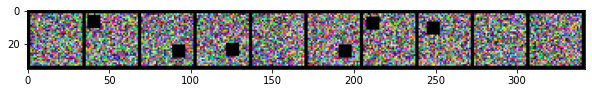

In [148]:
# 배치 형태를 시각화
# torchvision.utils.make_grid 사용

import torchvision

dataiter1 = iter(data_loader)
images1, labels1 = dataiter1.next()

def imshow(img):
  plt.figure(figsize=(10,100))
  plt.imshow(img.permute(1,2,0).numpy())
  plt.show

imshow(torchvision.utils.make_grid(images1, nrow=10))

# **커스텀 데이터 + 파이토치 제공 전처리(커스텀 데이터가 PIL 타입의 이미지가 아닐 경우)**
### - 파이토치 제공 전처리는 이미지가 PIL 타입일 경우 사용 가능
### - PIL이 아닐 경우 PIL로 변환 후 적용 가능
### - tr.Compose 대신 클래스를 통한 전처리 선언해주어야 함

In [149]:
class MyTransform:

  def __call__(self, sample):
    inputs, labels = sample
    inputs = torch.FloatTensor(inputs)
    inputs = inputs.permute(2,0,1)
    labels = torch.FloatTensor(labels)

    transf = tr.Compose([tr.ToPILImage(), tr.Resize(128), tr.ToTensor()])
    output = transf(inputs)

    return output, labels

In [151]:
class TensorData(Dataset):

  def __init__(self, x, y, transform=None):
    self.x = x
    self.y = y
    self.len = len(y)
    self.transform = transform
    self.tensor = ToTensor()
  
  # 전처리 과정 넣어주기
  def __getitem__(self, index):
    sample =  self.x[index], self.y[index]

    # 전처리 진행해주기
    if self.transform :
      sample = self.transform(sample)
    # 아니면 그냥 텐서형태로만 변환
    
    return sample

  
  def __len__(self):
    return self.len
    # or return len(self.y)
    # or return self.y.shape[0]

In [152]:
dataset = TensorData(train_images, train_labels, transform=MyTransform())
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

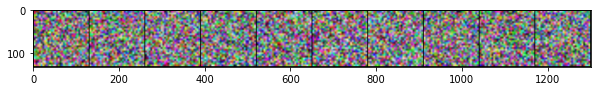

In [153]:
# 배치 형태를 시각화
# torchvision.utils.make_grid 사용

import torchvision

dataiter1 = iter(data_loader)
images1, labels1 = dataiter1.next()

def imshow(img):
  plt.figure(figsize=(10,100))
  plt.imshow(img.permute(1,2,0).numpy())
  plt.show

imshow(torchvision.utils.make_grid(images1, nrow=10))

# **PIL 타입 + 파이토치 제공 전처리**
### - 맨 처음처럼 tr.Compose 통해서 제공되는 전처리 적용하면 됨

# **PIL 타입 + 커스텀 전처리**
### - 커스텀 전처리가 라벨은 받지 않고, 이미지만 받아 처리하도록 세팅해줘야 (위와 비교)
### - 파이토치 제공 전처리는 이미지만 받아 처리하기에 같이 사용하기 위해선 맞춰줘야 함
### - 커스텀 전처리는 PIL에서 오류가 나기에 tr.ToTensor()로 텐서 변환 뒤에 위치시킨다!!
### - **즉!! 커스텀 데이터에 대해서도 파이토치 제공 전처리와 커스텀 전처리를 함께 사용하기 위해선 커스텀 전처리가 이미지만 받도록 세팅해야하며, 텐서 타입 변환 뒤에 위치시키면 된다!! **

In [164]:
# CutOut 전처리 (이미지 내부에 무작위 사각형 선택하여 0으로 만듦)

class CutOut:
  def __init__(self, ratio=.5):
    self.ratio = int(1/ratio)
  
  def __call__(self, inputs):
    active = int(np.random.randint(0, self.ratio, 1))  # 0~self.ratio 사이 정수에서 1개 추출  # 기본값에서는 0과 2-1 사이에서 뽑으므로, 0이 나올때 cutout 진행  # ratio에 따라 cutout 될 확률 변화

    if active==0:
      _, w, h = inputs.shape
      min_len = min(w, h)
      box_size = int(min_len//4)
      idx = int(np.random.randint(0, min_len-box_size, 1))
      inputs[:, idx:idx+box_size, idx:idx+box_size] = 0
  
    return inputs

In [165]:
transf = tr.Compose([tr.Resize(128), tr.ToTensor(), CutOut()])
!mkrdir ./custom2
trainset = torchvision.datasets.CIFAR100(root="./custom2", train=True, download=True, transform=transf)

/bin/bash: mkrdir: command not found


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./custom2/cifar-100-python.tar.gz to ./custom2


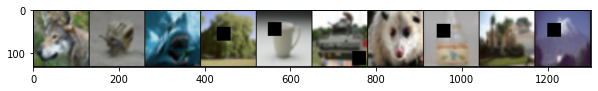

In [167]:
data_loader = DataLoader(trainset, batch_size=10, shuffle=True)

import torchvision

dataiter1 = iter(data_loader)
images1, labels1 = dataiter1.next()

def imshow(img):
  plt.figure(figsize=(10,100))
  plt.imshow(img.permute(1,2,0).numpy())
  plt.show

imshow(torchvision.utils.make_grid(images1, nrow=10))

In [168]:
# 텐서 -> 커스텀 -> 리사이즈
transf = tr.Compose([tr.ToTensor(), CutOut(), tr.Resize(128)])
!mkrdir ./custom3
trainset = torchvision.datasets.CIFAR100(root="./custom3", train=True, download=True, transform=transf)

/bin/bash: mkrdir: command not found


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./custom3/cifar-100-python.tar.gz to ./custom3


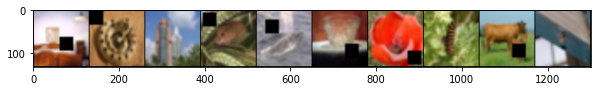

In [169]:
data_loader = DataLoader(trainset, batch_size=10, shuffle=True)

import torchvision

dataiter1 = iter(data_loader)
images1, labels1 = dataiter1.next()

def imshow(img):
  plt.figure(figsize=(10,100))
  plt.imshow(img.permute(1,2,0).numpy())
  plt.show

imshow(torchvision.utils.make_grid(images1, nrow=10))

# **연습**
### - 커스텀 데이터 + 파이토치 전처리 써보기
### - 단, 전처리 클래스 새로 안만들고 tr.Compose 사용
### - 이를 위해서 커스텀 데이터 불러올 때, sample을 input과 label로 나누어 구분해주면 됨!!!

In [170]:
train_images = np.random.randint(256, size=(100, 32, 32, 3))/255
train_labels = np.random.randint(2, size=(100,1))  

In [174]:
class TensorData(Dataset):

  def __init__(self, x, y, transform=None):
    self.x = torch.FloatTensor(x)
    self.x = self.x.permute(0,3,1,2)  # (이미지 수)x(너비)x(높이)x(채널 수) -> (배치 크기)x(채널 수)x(너비)x(높이)   # (100, 3, 32, 32)
    self.y = torch.LongTensor(y)
    self.len = len(y)
    self.transform = transform
    self.tensor = tr.ToTensor()
  
  # 전처리 과정 넣어주기
  ####### 이 부분을 나누어 줘야함!!!!!!!!!!!!
  def __getitem__(self, index):
    inputs =  self.x[index]
    labels = self.y[index]

    # 전처리 진행해주기
    if self.transform :
      inputs = self.transform(inputs)
    # 아니면 그냥 텐서형태로만 변환
    else:
      inputs = self.tensor(inputs)
    
    return inputs, labels

  
  def __len__(self):
    return self.len
    # or return len(self.y)
    # or return self.y.shape[0]

In [175]:
transf = tr.Compose([tr.ToPILImage(), tr.Resize(128), tr.ToTensor()])
dataset = TensorData(train_images, train_labels, transform=transf)
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

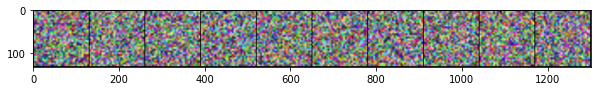

In [176]:
# 배치 형태를 시각화
# torchvision.utils.make_grid 사용

import torchvision

dataiter1 = iter(data_loader)
images1, labels1 = dataiter1.next()

def imshow(img):
  plt.figure(figsize=(10,100))
  plt.imshow(img.permute(1,2,0).numpy())
  plt.show

imshow(torchvision.utils.make_grid(images1, nrow=10))